In [1]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import glob
from matplotlib import pyplot as plt

import matplotlib.animation as animation
import os
import torch
import numpy as np

from scipy.ndimage import gaussian_filter
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')


from distributions import ZeroInflatedDist, QuantizedNormal
from torch_models import MixtureOfTruncNormModel
from torch_training import train_epoch


In [2]:
rows=27
cols=60
grid_size=(rows, cols)

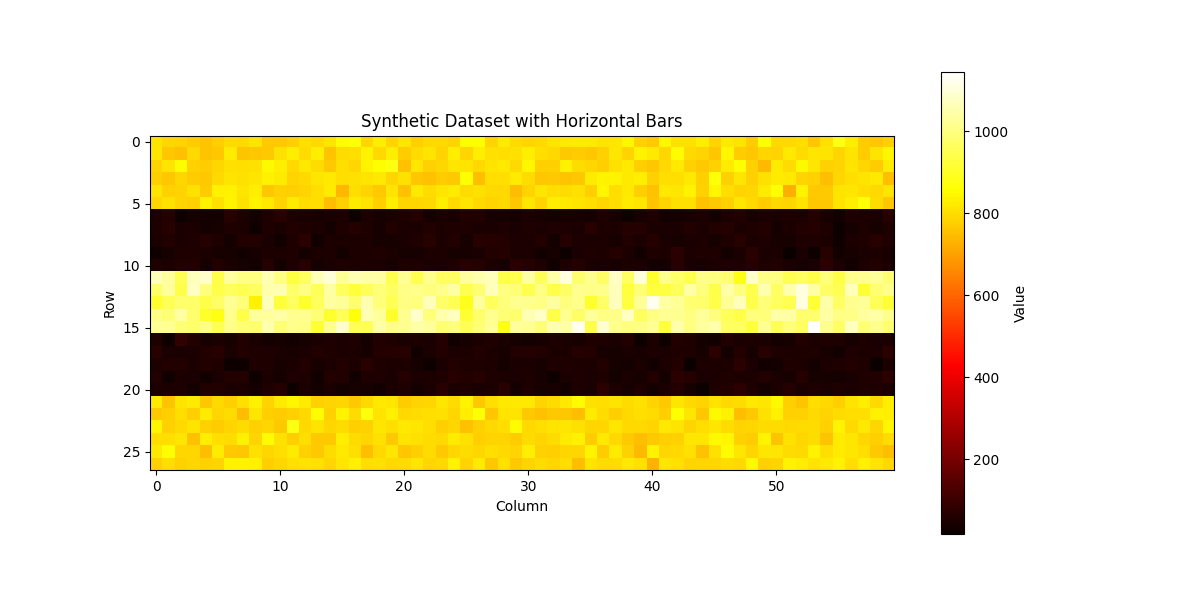

Dataset shape: (27, 60)
Value range: 17.98 to 1144.43
Mean value: 559.11
Number of rows in each bar (top to bottom): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def generate_horizontal_bar_dataset(rows=27, cols=60):
    # Initialize the grid
    grid = np.zeros((rows, cols))
    
    # Calculate the height of each bar
    middle_bar_height = rows // 5
    top_bottom_bar_height = (rows - 3 * middle_bar_height) // 2
    
    # Generate the bars
    bar_heights = [top_bottom_bar_height, middle_bar_height, middle_bar_height, middle_bar_height, top_bottom_bar_height]
    
    current_row = 0
    for i, height in enumerate(bar_heights):
        end_row = current_row + height
        
        if i == 2:  # Middle bar
            grid[current_row:end_row, :] = np.random.normal(1000, 50, (height, cols))
        elif i == 0 or i == 4:  # Top and bottom bars
            grid[current_row:end_row, :] = np.random.normal(800, 25, (height, cols))
        else:  # 2nd and 4th bars
            grid[current_row:end_row, :] = np.random.normal(50, 10, (height, cols))
        
        current_row = end_row
    
    # Ensure all values are non-negative
    grid = np.maximum(grid, 0)
    
    return grid

# Generate the dataset
pop_grid = generate_horizontal_bar_dataset()

# Visualize the dataset
plt.figure(figsize=(12, 6))
plt.imshow(pop_grid, cmap='hot', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Synthetic Dataset with Horizontal Bars')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

# Print some statistics
print(f"Dataset shape: {pop_grid.shape}")
print(f"Value range: {pop_grid.min():.2f} to {pop_grid.max():.2f}")
print(f"Mean value: {pop_grid.mean():.2f}")

# Print the number of rows in each bar
bar_heights = [sum(pop_grid[:, 0] == val) for val in np.unique(pop_grid[:, 0])]
print("Number of rows in each bar (top to bottom):", bar_heights)

In [4]:
def create_v_shape(center_position,  v_length, grid_size, value=2.5, direction='left', filter_sigma=1):
    """Create a V-shaped pattern centered at the specified position."""
    grid = np.zeros(grid_size)
    x_center, y_center = center_position

    if direction == 'left':
        first_x_offset_sign = 3
        second_x_offset_sign = -3
        first_y_offset_sign = 1
        second_y_offset_sign = 1
    elif direction == 'right':
        first_x_offset_sign = 1
        second_x_offset_sign = -1
        first_y_offset_sign = -1
        second_y_offset_sign = -1
    elif direction == 'up':
        first_x_offset_sign = 1
        second_x_offset_sign = 1
        first_y_offset_sign = 1
        second_y_offset_sign = -1
    elif direction == 'down':
        first_x_offset_sign = -1
        second_x_offset_sign = -1
        first_y_offset_sign = 1
        second_y_offset_sign = -1

    
    for offset in range(0, v_length + 1):
        # Calculate positions for the V branches
        first_branch_position = (x_center + first_x_offset_sign*offset, y_center + first_y_offset_sign*offset)
        second_branch_position = (x_center + second_x_offset_sign*offset, y_center + second_y_offset_sign*offset)
        
        # Ensure branches are within grid boundaries
        if 0 <= first_branch_position[0] < grid_size[0] and 0 <= first_branch_position[1] < grid_size[1]:
            grid[first_branch_position] = value
        
        if 0 <= second_branch_position[0] < grid_size[0] and 0 <= second_branch_position[1] < grid_size[1]:
            grid[second_branch_position] = value
    
    return gaussian_filter(grid, sigma=filter_sigma)

In [11]:
death_rates = []
deaths = []
#north_south_init = (0, 52)
east_west_init = (13, 52)
frames = 52
for time in range(frames):
    #north_south_loc = (north_south_init[0]+time, north_south_init[1])
    #north_south_v = create_v_shape(north_south_loc, np.max(grid_size), grid_size, direction='down')

    #if north_south_loc[0] == east_west_init[0]:
    start_time = 0
    #if north_south_loc[0] >= east_west_init[0]:
    east_west_loc = (east_west_init[0], east_west_init[1]-time+start_time)
    east_west_v = create_v_shape(east_west_loc, np.max(grid_size), grid_size,value=8, direction='left', filter_sigma=0.7)
    #else:
    #    east_west_v = np.zeros(grid_size)

    
    grid = np.zeros(grid_size)  + east_west_v + np.random.rand(*grid_size)*0.1
    death_rate = grid*0.005
    death_rates.append(death_rate)
    deaths.append(pop_grid*death_rate)

In [12]:
def update_death(frame):
    global deaths
    img.set_data(deaths[frame])
    return [img]

def update_death_rate(frame):
    global death_rates
    img.set_data(death_rates[frame])
    return [img]

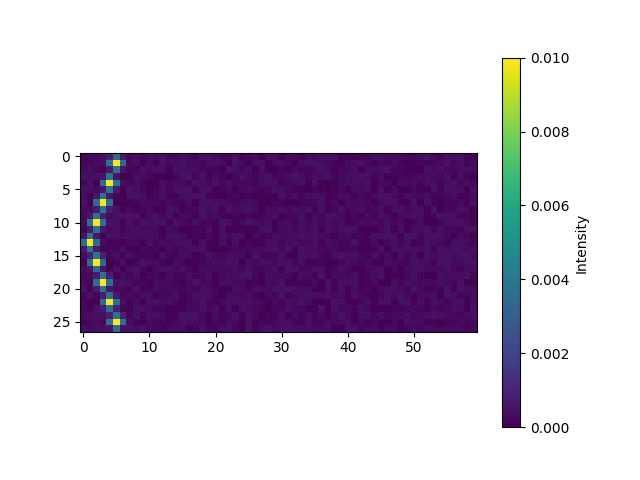

In [13]:
%matplotlib widget
# Prepare the figure for animation
fig, ax = plt.subplots()
img = ax.imshow(grid, cmap='viridis', vmin=0, vmax=0.01)
plt.colorbar(img, label='Intensity')



# Animate the grid
ani = animation.FuncAnimation(fig, update_death_rate, frames=frames, interval=100, blit=True)
ani.save('death_ratesbandsteeper.mp4')


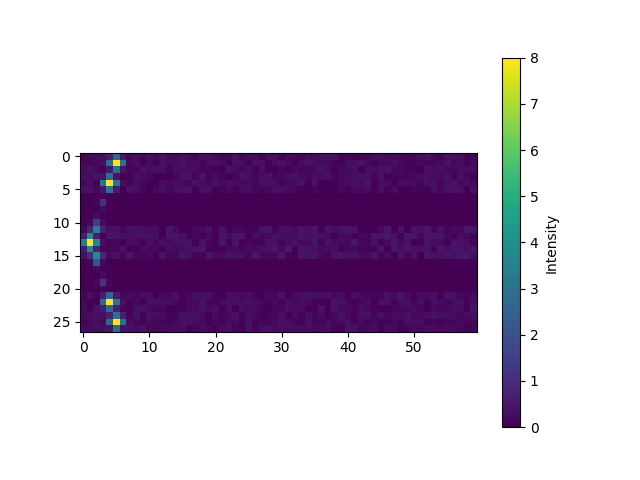

In [14]:
%matplotlib widget
# Prepare the figure for animation
fig, ax = plt.subplots()
img = ax.imshow(grid, cmap='viridis', vmin=0, vmax=8)
plt.colorbar(img, label='Intensity')



# Animate the grid
ani = animation.FuncAnimation(fig, update_death, frames=frames, interval=100, blit=True)
ani.save('deaths_bandsteeper.mp4')



In [9]:
import pandas as pd
full_df = pd.DataFrame()
for time in range(frames):
    num_rows = grid_size[0]*grid_size[1]
    geoid_col = np.arange(num_rows)
    time_col = time * np.ones(num_rows)
    death_rate_col = death_rates[time].flatten()
    death_col = deaths[time].flatten()
    df = pd.DataFrame({'geoid': geoid_col, 'time': time_col, 'death_rate': death_rate_col, 'death': death_col})
    full_df = pd.concat([full_df, df], ignore_index=True)

In [10]:
full_df.to_csv('deaths_bandheavysteep.csv', index=False)
pop_df = pd.DataFrame({'geoid': geoid_col, 'pop': pop_grid.flatten()})
pop_df.to_csv('pop_bandheavysteep.csv', index=False)